In [1]:
import seaborn
import pandas
from pathlib import Path
import re
import numpy
import sklearn.svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.ensemble
from matplotlib import pyplot as plt
seaborn.set_theme(style="whitegrid", palette="pastel")

In [2]:
in_folder = Path("./results/t0")
files = in_folder.glob("*droplets_table.csv")

In [3]:
def extract_features(df):
    grouped = df.loc[df["AtlasMapping"]!=0].groupby("AtlasMapping")
    n_droplets_per_cell = grouped.size().to_numpy()
    droplet_area_per_cell = grouped["Size in pixels"].sum().to_numpy()
    
    features = {
        "med_droplet_area_per_cell": numpy.median(droplet_area_per_cell),
        "med_mean_droplet_intensity_per_cell": numpy.median(grouped["Mean Intensity"].mean().to_numpy()),
        "med_n_droplets_per_cell":  numpy.median(n_droplets_per_cell),
    }
    return features

def plate_coordinates(path):
    """extract plate coordinates from filename
    e.g.
        B - 02(fld 2 wv FITC - FITC)_droplets_table
        -> (B, 2, 2)
    """
    ptrn = re.compile("(?P<y>[B-G]) - (?P<x>[\d]{2})\(fld (?P<field>[1-3])")
    groupdict = ptrn.match(str(path.name)).groupdict()
    groupdict["x"] = int(groupdict["x"])
    groupdict["field"] = int(groupdict["field"])
    return groupdict

In [4]:
data = []
for f in in_folder.glob("*droplets_table.csv"):
    key = plate_coordinates(f)
    df = pandas.read_csv(f)
    features = extract_features(df)
    features.update(key)
    data.append(features)

In [5]:
fdf = pandas.DataFrame(data)
fdf.set_index(["y", "x", "field"], inplace=True)

In [6]:
training_feature_keys = ["med_droplet_area_per_cell", "med_n_droplets_per_cell", "med_mean_droplet_intensity_per_cell"]

gt_0 = [(y, 2, field) for field in range(1,4) for y in "BCDEFG"]
gt_1 = [(y, 3, field) for field in range(1,4) for y in "BCDEFG"]
gt_coords = gt_0 + gt_1
Y = [0 for x in gt_0] + [1 for x in gt_1]
W = ["untreated" for x in gt_0] + ["treated" for x in gt_1]

fdf.loc[gt_coords, "label"] = Y
fdf.loc[gt_coords, "class"] = W
fdf["all"] = ""
X = fdf.loc[gt_coords, training_feature_keys].values

/home/kutra/miniconda3/envs/da/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


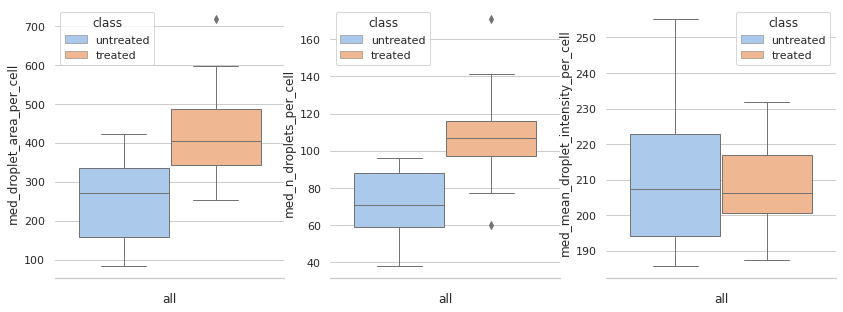

In [7]:
fig, axs = plt.subplots(ncols=len(training_feature_keys),nrows=1,figsize=(14,5))
for i, feat in enumerate(training_feature_keys):
    seaborn.boxplot(data=fdf.loc[gt_coords], x="all", y=feat, hue="class", ax=axs[i], linewidth=1)
    seaborn.despine(left=True)

In [8]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
clf.fit(X, Y)
print("ACC", clf.score(X, Y))

ACC 1.0


In [9]:
all_d = fdf.loc[:, training_feature_keys]
preds = clf.predict(all_d)

In [10]:
fdf = fdf.assign(prediction=preds)

In [11]:
plate_predictions = fdf.groupby(["y", "x"])["prediction"].sum() >= 2

In [12]:
coords = [("ABCDEFGHI".index(y), x) for y, x in plate_predictions.index.to_numpy()]
pred_img = numpy.ones((8, 13)) * -1

In [13]:
pred_img[[x[0] for x in coords], [x[1] for x in coords]] = plate_predictions

(1.0, 13.0)

/home/kutra/miniconda3/envs/da/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


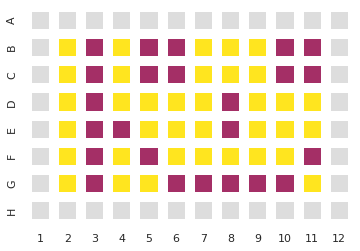

In [14]:
p = seaborn.heatmap(
    pred_img,
    cmap=["#DDD", "#FFE51F", "#A42F66"],
    cbar=False,
    square=True,
    vmin=-1,
    vmax=1,
    linewidths=10,
    yticklabels="ABCDEFGH"
)
p.set_xlim([1, 13])

In [15]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
Y = numpy.array(Y)
acc = []
for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
    clf.fit(X_train, Y_train)
    acc.append(clf.score(X_test, Y_test))
print("Leave one out result (per field):", sum(acc)/len(acc))

Leave one out result (per field): 0.8611111111111112
